**This project aims to classify an email into spam or ham. We'll be using natural language processing (NLP) for this task.**

In [1]:
#import the required libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
#import CountVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
#import tfidftransformer
from sklearn.feature_extraction.text import TfidfTransformer
#import Multinomial Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB
#import decision tree classifier
from sklearn.tree import DecisionTreeClassifier
#import random forest classifier
from sklearn.ensemble import RandomForestClassifier
import string
from nltk.corpus import stopwords

In [2]:
#load the dataset
emails = pd.read_csv('emails.csv')
emails.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


We can see that the dataset contains columns as 'subject', 'message' and the 'label'

Subject is the email subject

message contains the body of the email

label is target class where 0 indicates a non spam (ham) email and 1 indicates a spam email

In [3]:
#let us have a look at some subjects and messages
emails['subject'][0]

'job posting - apple-iss research center'

In [4]:
emails['message'][0]

"content - length : 3386 apple-iss research center a us $ 10 million joint venture between apple computer inc . and the institute of systems science of the national university of singapore , located in singapore , is looking for : a senior speech scientist - - - - - - - - - - - - - - - - - - - - - - - - - the successful candidate will have research expertise in computational linguistics , including natural language processing and * * english * * and * * chinese * * statistical language modeling . knowledge of state-of - the-art corpus-based n - gram language models , cache language models , and part-of - speech language models are required . a text - to - speech project leader - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - the successful candidate will have research expertise expertise in two or more of the following areas : computational linguistics , including natural language parsing , lexical database design , and statistical language modeling ; text tokenization and

In [5]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893 entries, 0 to 2892
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  2831 non-null   object
 1   message  2893 non-null   object
 2   label    2893 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 67.9+ KB


By looking at the info, we can observe that the subject column contains some missing values

In [6]:
#check the shape of the dataset
emails.shape

(2893, 3)

As we can see, the dataset contains 2893 records of emails and 3 columns.

### Exploratory Data Analysis

In [7]:
emails.describe(include='all')

,subject,message,label
count,2831,2893,2893.000000
unique,2613,2859,NaN
top,sociolinguistics,this is not spam ; you are receiving this mess...,NaN
freq,8,5,NaN
mean,NaN,NaN,0.166263
std,NaN,NaN,0.372381
min,NaN,NaN,0.000000
25%,NaN,NaN,0.000000
50%,NaN,NaN,0.000000
75%,NaN,NaN,0.000000


In [8]:
emails.groupby('label').describe()

subject                               message         \
        count unique               top freq   count unique   
label                                                        
0        2363   2193  sociolinguistics    8    2412   2401   
1         468    420              re :    7     481    458   

                                                               
                                                     top freq  
label                                                          
0      names , the journal of the american name socie...    2  
1      this is not spam ; you are receiving this mess...    5

Here, we can observe that interesting the spam messages contain the words 'this is not spam'.

In [9]:
#check distribution of the target class
emails['label'].value_counts()

0    2412
1     481
Name: label, dtype: int64

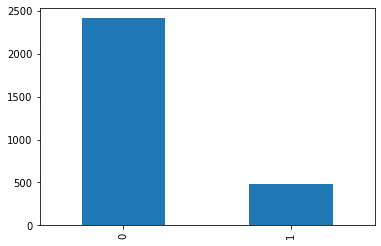

In [10]:
emails['label'].value_counts().plot(kind='bar')

We can see that the target classes are imbalanced with more instances of ham emails than spam emails with the ratio being approx. equal to 5:1 in that order.

In [11]:
#let us have a look whether we have missing data or not
emails.isnull().sum()

subject    62
message     0
label       0
dtype: int64

As we can see, we have 62 instances of missing data in the subject column

This means that 62 emails are not having any subject line for the email. 

As of now, we'll be keeping these records as is, as we'll only focus on the email message part.

In [12]:
#let us create a new column to check the length of the email messages
emails['length'] = emails['message'].apply(len)
emails.head()

,subject,message,label,length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,2856
1,NaN,"lang classification grimes , joseph e . and ba...",0,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,1435
3,risk,a colleague and i are researching the differin...,0,324
4,request book information,earlier this morning i was on the phone with a...,0,1046


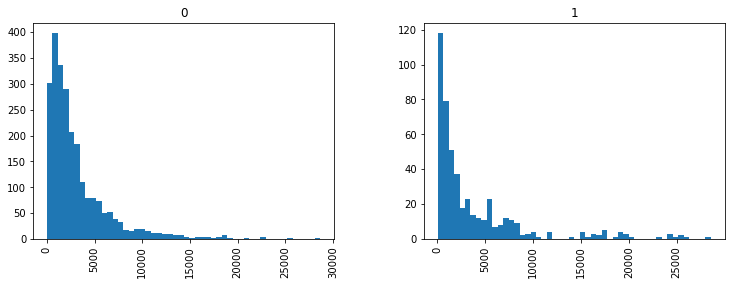

In [13]:
#let us visualize the length column based on the label column
emails.hist(column='length', by='label', bins=50, figsize=(12,4))
plt.show()

We can observe that the distribution is similar for both classes.

### Text Pre-Processing 

In [14]:
#let us define a function to remove all punctuations and stopwords from our email message
def text_process(mess):
    
    """Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    
    #remove characters that are punctuations with the string library
    nopunc = [char for char in mess if char not in string.punctuation]
    
    #join characters to form a string
    nopunc = ''.join(nopunc)
    
    #remove the stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [15]:
#apply the function on the message column to check
emails['message'].apply(text_process)

0       [content, length, 3386, appleiss, research, ce...
1       [lang, classification, grimes, joseph, e, barb...
2       [posting, inquiry, sergei, atamas, satamas, um...
3       [colleague, researching, differing, degrees, r...
4       [earlier, morning, phone, friend, mine, living...
                              ...                        
2888    [hello, thanks, stopping, taken, many, new, pi...
2889    [list, owner, kiddin, invited, join, mailing, ...
2890    [judging, return, post, must, sounded, like, k...
2891    [gotcha, two, separate, fallacies, argument, n...
2892    [hello, working, thesis, concerning, attitudes...
Name: message, Length: 2893, dtype: object

**Train test split**

In [16]:
#perform a 80:20 train test split on the data
msg_train, msg_test, label_train, label_test = train_test_split(emails['message'], emails['label'], test_size=0.2, 
                                                                random_state=10)

#check the lengths of the splits
print(len(msg_train), len(msg_test), len(label_train), len(label_test))

2314 579 2314 579


Next we have to have to perform:
1. convert strings to integer counts for the sklearn algorithms to work on
2. convert the integer counts to weighted TF-IDF scores
3. train on TF-IDF vectors w.r.t ML classifiers. 

### Creating a data pipeline and Model Building

We will use SciKit Learn's pipeline capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use

We'll first train our model and check our scores on the **Multinomial Naive bayes classifier**

In [17]:
#create the pipeline for Multinomial NB classifier
pipeline_NB = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

In [18]:
#fit the model on train data
pipeline_NB.fit(msg_train, label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x00000250A7FFCDC8>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [19]:
#set the no of splits on train data for cross validation
kf = KFold(n_splits=3, shuffle=True, random_state=10)

In [20]:
#we will now use cross validation to avoid causing overfitting on our NB model
scores_NB = cross_val_score(pipeline_NB, msg_train, label_train, cv=kf, scoring='roc_auc', n_jobs=1)

print("Multinomial NB scores:", scores_NB)
print("Multinomial NB Bias error:", 1 - np.mean(scores_NB))
print("Multinomial NB Variance error:", np.std(scores_NB, ddof=1))

Multinomial NB scores: [0.99716218 0.99533714 0.99619816]
Multinomial NB Bias error: 0.0037675055930894708
Multinomial NB Variance error: 0.0009130043199039761


We have acheived ROC scores of 99. Let us predict on the test set

In [21]:
y_pred_NB = pipeline_NB.predict(msg_test)

In [22]:
print("ROC score on test set for Multinomial NB model:", roc_auc_score(label_test, 
                                                                       pipeline_NB.predict_proba(msg_test)[:,1]))

ROC score on test set for Multinomial NB model: 0.9990319865319865


We can have achieved good scores on the test data as well. 

Let us try and experiment with a decision tree classifier.

### Decision tree classifier

Let us train our model on the decision tree classifier

In [23]:
#initialize the pipeline

pipeline_DT = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),
    ('classifier', DecisionTreeClassifier(random_state=10))
])

In [24]:
#fit the model on train data
pipeline_DT.fit(msg_train, label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x00000250A7FFCDC8>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', DecisionTreeClassifier(random_state=10))])

In [25]:
#use cross validation and print the scores
scores_DT = cross_val_score(pipeline_DT, msg_train, label_train, cv=kf, scoring='roc_auc', n_jobs=1)

print("DTC scores:", scores_DT)
print("DTC Bias error:", 1 - np.mean(scores_DT))
print("DTC Variance error:", np.std(scores_DT, ddof=1))

DTC scores: [0.91809205 0.86838783 0.91490015]
DTC Bias error: 0.09953998888420357
DTC Variance error: 0.02782114068183381


We have achieved roc auc score of 0.91 on the train set.

In [26]:
#predicting score on test set
y_pred_DT = pipeline_DT.predict(msg_test)

print("ROC score on test set:", roc_auc_score(label_test, pipeline_DT.predict_proba(msg_test)[:,1]))

ROC score on test set: 0.9194444444444444


The ROC AUC score on the test set is 0.91.

Lets check with a random forest classifier for better scores

### Random Forest Classifier

In [27]:
#initialize the pipeline
pipeline_RF = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=10))
])

In [28]:
#fit the model on train data
pipeline_RF.fit(msg_train, label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x00000250A7FFCDC8>)),
                ('tfidf', TfidfTransformer()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=50, random_state=10))])

In [29]:
#use cross validation and print the scores
scores_RF = cross_val_score(pipeline_RF, msg_train, label_train, cv=kf, scoring='roc_auc', n_jobs=1)

print("RFC scores:", scores_RF)
print("RFC Bias error:", 1 - np.mean(scores_RF))
print("RFC Variance error:", np.std(scores_RF, ddof=1))

RFC scores: [0.99902167 0.99925793 0.99975678]
RFC Bias error: 0.0006545398325435992
RFC Variance error: 0.00037529447500616746


We have achieved a mean roc score 0.99 on the train set.

In [30]:
#predicting score on test set
y_pred = pipeline_RF.predict(msg_test)

print("ROC score on test set:", roc_auc_score(label_test, pipeline_RF.predict_proba(msg_test)[:,1]))

ROC score on test set: 0.999810606060606


The ROC score on the test set is 0.99.

In [33]:
print(confusion_matrix(label_test, y_pred))

[[483   1]
 [  5  90]]


In [31]:
print(classification_report(label_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       480
           1       1.00      0.87      0.93        99

    accuracy                           0.98       579
   macro avg       0.99      0.93      0.96       579
weighted avg       0.98      0.98      0.98       579



In [ ]:
#We can now infer that the Multinomial Naive Bayes and Random forest are the two best models.